In [298]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from  keras.models import Sequential,Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

from keras.callbacks import TensorBoard
import time 

In [299]:
NAME = 'car_jeep_truck_detector_resnet50-{}'.format(int(time.time()))
tensorborad = TensorBoard(log_dir='logs/{}'.format(NAME))

In [300]:
NUMBER_CLASSES  = 3

IMAGE_RESIZE = 224
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 16
BATCH_SIZE_VALIDATION = 16
BATCH_SIZE_TESTING = 1

In [301]:
base_model = ResNet50(weights="imagenet",include_top=False)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [302]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000,activation="relu")(x)
x = Dropout(0.5)(x)
pred = Dense(NUMBER_CLASSES,activation="softmax")(x)

In [303]:
model = Model(inputs=base_model.input, outputs=pred)

In [304]:
for layer in model.layers[:170]:
    layer.trainable = False
#for layer in  model.layers:
#    print(layer.trainable)

In [305]:
#since data is small, no need to train network

#for layer in model.layers[:90]:
#    layer.trainable = False
#for layer in model.layers[90:]:
#    layer.trainable = True

In [306]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True, 
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                "train/",
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_TRAINING,
                                class_mode='categorical',
                                subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
                                "train/", # same directory as training data
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_VALIDATION,
                                class_mode='categorical',
                                subset='validation') # set as validation data

Found 36 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [307]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'weights/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [308]:
#vue que c'est du transfert learning, il faut que le learning rate soit très petit
sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss="categorical_crossentropy", metrics=["accuracy"])

In [309]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper,tensorborad])

Epoch 1/20
10/10 [==============================] - 46s 5s/step - loss: 1.3594 - acc: 0.3460 - val_loss: 1.4539 - val_acc: 0.3556
Epoch 2/20
10/10 [==============================] - 34s 3s/step - loss: 1.3183 - acc: 0.3847 - val_loss: 1.4497 - val_acc: 0.3667
Epoch 3/20
10/10 [==============================] - 32s 3s/step - loss: 1.3467 - acc: 0.3969 - val_loss: 1.4388 - val_acc: 0.3556
Epoch 4/20
10/10 [==============================] - 34s 3s/step - loss: 1.3810 - acc: 0.3484 - val_loss: 1.4312 - val_acc: 0.3444
Epoch 5/20
10/10 [==============================] - 34s 3s/step - loss: 1.2700 - acc: 0.4018 - val_loss: 1.4167 - val_acc: 0.3444
Epoch 6/20
10/10 [==============================] - 32s 3s/step - loss: 1.0921 - acc: 0.4245 - val_loss: 1.4144 - val_acc: 0.3333
Epoch 7/20
10/10 [==============================] - 33s 3s/step - loss: 1.2166 - acc: 0.4274 - val_loss: 1.4062 - val_acc: 0.3333
Epoch 8/20
10/10 [==============================] - 34s 3s/step - loss: 1.1573 - acc: 0.38

In [310]:
model.load_weights("weights/best.hdf5")

In [311]:
test_datagen = ImageDataGenerator(rescale=1./255) 
test_generator = test_datagen.flow_from_directory(
                                "test/",
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_TESTING,
                                class_mode='categorical') # set as training data

Found 9 images belonging to 3 classes.


In [312]:
#for property_, value in vars(test_generator).items():
#    print (property_, ": ", value)

In [313]:
len(test_generator.filenames )

9

In [314]:
steps = len(test_generator.filenames)/BATCH_SIZE_TESTING
result = model.predict_generator(test_generator,verbose=1,steps=steps)

9/9 [==============================] - 6s 633ms/step


In [315]:
print(result)

[[ 0.08119081  0.41590619  0.50290304]
 [ 0.08645633  0.41042158  0.50312209]
 [ 0.10347017  0.41498163  0.48154819]
 [ 0.09592853  0.4243544   0.47971714]
 [ 0.09525856  0.39373595  0.51100552]
 [ 0.09772301  0.36080599  0.541471  ]
 [ 0.09182964  0.45364392  0.45452648]
 [ 0.09935886  0.38335329  0.51728785]
 [ 0.09234996  0.40649647  0.50115359]]


In [316]:
predicted_class_indices=np.argmax(result,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [317]:
print(predictions)

['truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck', 'truck']


In [255]:
for file in test_generator.filenames:
    print(file)

car/image1.jpg
car/image2.jpg
car/image3.jpg
jeep/image1.jpg
jeep/image2.jpg
jeep/image3.jpg
truck/image1.jpg
truck/image2.jpg
truck/image3.jpg


In [256]:
model.evaluate_generator(test_generator,steps)

[1.3198792868190341, 0.33333333333333331]

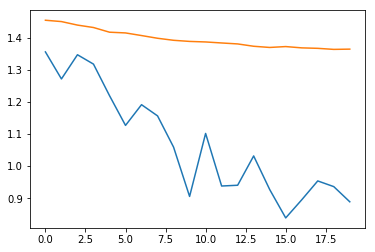

In [318]:
plt.plot(fit_history.history["loss"])
plt.plot(fit_history.history["val_loss"])
plt.show()

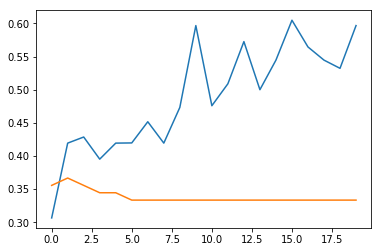

In [319]:
plt.plot(fit_history.history["acc"])
plt.plot(fit_history.history["val_acc"])
plt.show()

In [258]:
#test with one image 
image_path = "test/car/image1.jpg"
image_pil = load_img(image_path)
image_array = img_to_array(image_pil)
image_batch = np.expand_dims(image_array, axis=0)

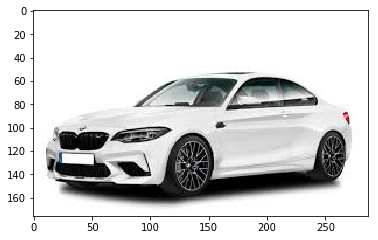

In [259]:
plt.imshow(np.uint8(image_batch[0]))
plt.show()

In [260]:
image_preprocess = preprocess_input(image_batch)

In [261]:
image_predict = model.predict(image_preprocess)

In [262]:
image_predict_index = np.argmax(image_predict)

In [263]:
#for prop,value in vars(test_generator).items():
#    print(prop,"-",value)

In [264]:
labels = {k:v for v,k in test_generator.class_indices.items()}

In [265]:
print(labels[image_predict_index])

car


In [266]:
#image_predict_decode = decode_predictions(image_predict)

In [267]:
layers = [layer.output for layer in model.layers[1:10]]

In [268]:
activation_model  = Model(inputs=model.input, outputs = layers )

In [269]:
activations = activation_model.predict(image_preprocess)

(1, 182, 293, 3)


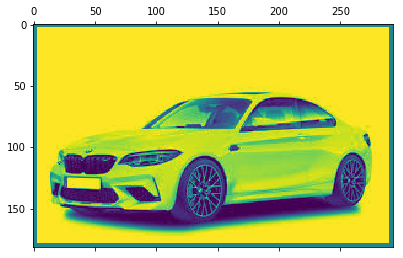

In [270]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 1])

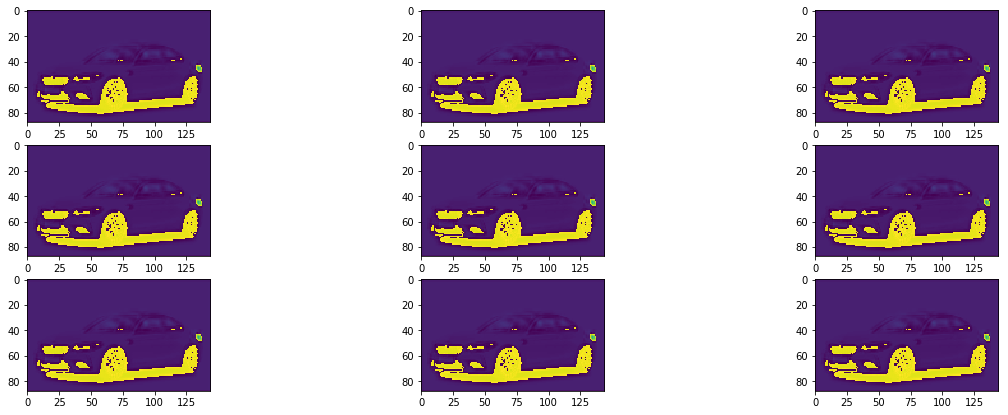

In [293]:
N_ROWS = 3
N_COLS = 3


fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS,figsize=(20,7))
#print(ax)
for index_i in range(0,N_ROWS):
    for index_j in range(0,N_COLS):
        ax[index_i][index_j].imshow(np.uint8(activations[1][0, :, :, 1]))